<h1>Mini Project 3: Brain Tumor Detection</h1>
<h4>By Patrick Chesnut</h4>
<span>GitHub: </span><a style="color:CornflowerBlue"><u>https://github.com/cu-cspb-4622-spring-2024/P3-chesnutpc</u></a>

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import os.path
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import models
from keras import layers
from keras.optimizers import RMSprop

wr.filterwarnings('ignore')

<h3>Project Topic</h3>

This project explores the development and implementation of a Convolutional Neural Network (CNN) to classify brain MRI scans into two categories: those that contain tumors and those that do not. The dataset is comprises 3000 JPEG images, evenly split between tumor-afflicted and normal scans. This project involves a binary <b>classification</b> problem.

The motivation behind this project stems from the need to provide early and accurate detection of brain tumors. Brain tumors can be life-threatening, and their treatment often depends on the stage at which they are diagnosed. Traditional methods of detection rely heavily on the expertise of radiologists to interpret MRI scans, a process that can be subjective and prone to error given the subtle nature of early tumors. By automating the detection process with a CNN, we aim to assist radiologists in making more accurate and timely diagnoses, potentially leading to better treatment strategies and improved survival rates for patients. Moreover, this project is not just a practical application of machine learning but also serves as an exploration into how deep learning techniques can be optimized for medical imaging tasks.


<h3>Data</h3>
The data for this project was obtained from Kaggle, a link is provided below:<br>
<a style="color:CornflowerBlue"><u>https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection/data</u></a>
<br><br>

Each image file in this dataset represents a single MRI scan, labeled as either containing a brain tumor or not.

The images are organized into two directories named 'yes' and 'no', each containing 1500 images. The 'yes' directory includes scans that depict various types and stages of brain tumors, whereas the 'no' directory contains scans that show no tumor presence. This clear division aids in straightforward training and validation processes for the convolutional neural network model.

Regarding the characteristics of the images, they vary in size and format. While the majority of the images are in greyscale, there are also some color images in the dataset. The complete dataset is relatively compact, with a total size of 88 MB, making it manageable for processing and analysis without requiring extensive computational resources.

There are no missing values as the data not contain values.

<h3>Data Cleaning and EDA</h3>
The initial step in the project workflow involves setting up the computing environment and preparing the data for analysis and model training. We utilize Google Colab, an online iPython notebook service that provides a powerful and flexible platform for executing Python code with the support of access to GPUs for deep learning tasks. The data for this project is first uploaded to Google Drive. This setup allows us to leverage the integration between Google Colab and Google Drive by mounting the Drive within the Colab notebook, thereby granting direct access to the dataset.

Once the data is accessible within the Colab environment, we proceed with the organization of the dataset into a structured format suitable for analysis and model training. We employ the Pandas library to create a DataFrame that contains two essential pieces of information for each image: the file path and a binary label indicating the presence ('yes') or absence ('no') of a tumor.

To ensure that the model generalizes well and does not simply memorize the order of the data, we shuffle the DataFrame. Shuffling is crucial as it prevents any biases that might occur due to the order in which data was originally presented. Following the shuffle, a subset of 25 scans is visualized using Matplotlib’s pyplot. This visualization aids in understanding the variations within the scans and in spotting any apparent anomalies or inconsistencies that might need further cleaning.

Finally, we split the data into training and testing sets to evaluate the performance of the model. The training set consists of 90% of the data, which allows the model to learn from a vast majority of the available examples, thereby optimizing its ability to detect patterns and make accurate predictions. The remaining 10% of the data forms the testing set, which is used to assess the model's performance on unseen data, simulating how it would perform in real-world diagnostic scenarios. This split not only supports the effective training of the model but also ensures that we have a robust measure to evaluate its generalization capabilities outside the training dataset.





In [2]:
# store the data in Google Drive, this will prompt you to allow access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import file paths for training data
NoTumorsFilePaths = Path('/content/drive/My Drive/Colab Notebooks/data/no')
YesTumorsFilePaths = Path('/content/drive/My Drive/Colab Notebooks/data/yes')
NoJPEGFiles = list(NoTumorsFilePaths.glob(r'*.jpg'))
YesJPEGFiles = list(YesTumorsFilePaths.glob(r'*.jpg'))

# Check to make sure file paths are correct
print(NoJPEGFiles[0:5])
print(YesJPEGFiles[0:5])

# Combine all file paths to one list
AllFilePaths = []
for x in NoJPEGFiles:
  AllFilePaths.append(x)

for x in YesJPEGFiles:
  AllFilePaths.append(x)

# Check to make sure file paths still correct
print(AllFilePaths[0:5])
print(AllFilePaths[-5:])

# Create list of labels
Labels = []
for x in range(1500):
  Labels.append('no')
for x in range(1500):
  Labels.append('yes')

# Dataframe of file paths and labels
PathSeries = pd.Series(AllFilePaths, name='Image').astype(str)
LabelSeries = pd.Series(Labels, name='Tumor')
AllData = pd.concat([PathSeries,LabelSeries], axis=1)
print(AllData)



[PosixPath('/content/drive/My Drive/Colab Notebooks/data/no/no1457.jpg'), PosixPath('/content/drive/My Drive/Colab Notebooks/data/no/no1441.jpg'), PosixPath('/content/drive/My Drive/Colab Notebooks/data/no/no146.jpg'), PosixPath('/content/drive/My Drive/Colab Notebooks/data/no/no1446.jpg'), PosixPath('/content/drive/My Drive/Colab Notebooks/data/no/no1444.jpg')]
[PosixPath('/content/drive/My Drive/Colab Notebooks/data/yes/y1451.jpg'), PosixPath('/content/drive/My Drive/Colab Notebooks/data/yes/y146.jpg'), PosixPath('/content/drive/My Drive/Colab Notebooks/data/yes/y1445.jpg'), PosixPath('/content/drive/My Drive/Colab Notebooks/data/yes/y1457.jpg'), PosixPath('/content/drive/My Drive/Colab Notebooks/data/yes/y1446.jpg')]
[PosixPath('/content/drive/My Drive/Colab Notebooks/data/no/no1457.jpg'), PosixPath('/content/drive/My Drive/Colab Notebooks/data/no/no1441.jpg'), PosixPath('/content/drive/My Drive/Colab Notebooks/data/no/no146.jpg'), PosixPath('/content/drive/My Drive/Colab Notebooks/

In [4]:
# Next we need to shuffle the data so images with/without tumor are mixed
AllData = AllData.sample(frac=1, random_state=4).reset_index(drop=True)
print(AllData)

                                                  Image Tumor
0     /content/drive/My Drive/Colab Notebooks/data/n...    no
1     /content/drive/My Drive/Colab Notebooks/data/y...   yes
2     /content/drive/My Drive/Colab Notebooks/data/y...   yes
3     /content/drive/My Drive/Colab Notebooks/data/n...    no
4     /content/drive/My Drive/Colab Notebooks/data/n...    no
...                                                 ...   ...
2995  /content/drive/My Drive/Colab Notebooks/data/y...   yes
2996  /content/drive/My Drive/Colab Notebooks/data/n...    no
2997  /content/drive/My Drive/Colab Notebooks/data/y...   yes
2998  /content/drive/My Drive/Colab Notebooks/data/n...    no
2999  /content/drive/My Drive/Colab Notebooks/data/n...    no

[3000 rows x 2 columns]


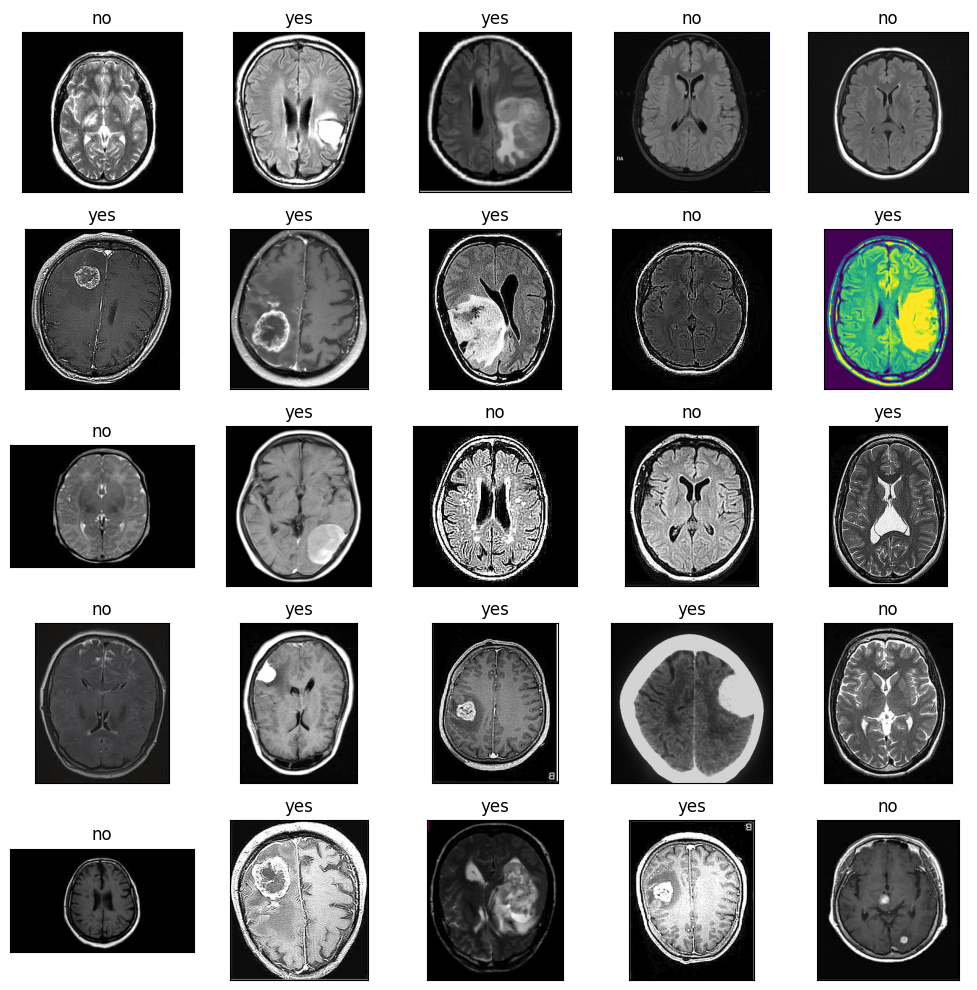

In [5]:
# We can now visualize some of the images
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(AllData["Image"][i]))
    ax.set_title(AllData["Tumor"][i])
plt.tight_layout()
plt.show()


In [6]:
# We can now split the data into a train set and test set
TrainData, TestData = train_test_split(AllData, train_size=0.9, random_state=1)
print(TrainData.shape)
print(TestData.shape)

(2700, 2)
(300, 2)


<h3>Model Building / Model Training</h3>

We first standarize the images to a uniform size of 200 x 200 pixels and converting them to greyscale.  This preprocessing step is necessary because CNNs require fixed-size inputs. By resizing the images, we ensure that the neural network's architecture does not need to accommodate variations in image size, which simplifies the model and reduces computational complexity. Converting images to greyscale simplifies the data further by reducing the number of channels in each image from three (in RGB color) to one. This reduction not only decreases the amount of computation required but also focuses the model's learning on the structural and textural information in the image, which is crucial for identifying tumors in MRI scans, rather than color features which are less relevant in this context.

Next, we split the training data into a train set and a validation. The training set is used to train the models, allowing them to learn and adjust their weights based on the provided examples. The validation set, however, is used to evaluate the model during the training process, providing feedback on how well the model is generalizing to new data. This split helps in monitoring for overfitting, where a model might perform exceptionally well on training data but poorly on unseen data.


In [7]:
# Note that images are not all the same size and some are colorized
# This step, we normalize all the images to 200 x 200 pixels, greyscale
# We also split the training data 90/10 for use in training the CNN
Generator_Basic = ImageDataGenerator(rescale=1./255, validation_split=0.1)
TrainSet = Generator_Basic.flow_from_dataframe(dataframe=TrainData,
                                                x_col="Image",
                                                y_col="Tumor",
                                                color_mode="grayscale",
                                                class_mode="categorical",
                                                subset="training",
                                                batch_size=20,
                                                target_size=(200,200))

ValidationSet = Generator_Basic.flow_from_dataframe(dataframe=TrainData,
                                                     x_col="Image",
                                                     y_col="Tumor",
                                                     color_mode="grayscale",
                                                     class_mode="categorical",
                                                     subset="validation",
                                                     batch_size=20,
                                                     target_size=(200,200))


Found 2430 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.


In [8]:
# Here we normalize the TestData
TestSet = Generator_Basic.flow_from_dataframe(dataframe=TestData,
                                              x_col="Image",
                                              y_col="Tumor",
                                              color_mode="grayscale",
                                              class_mode="categorical",
                                              batch_size=20,
                                              target_size=(200,200))

Found 300 validated image filenames belonging to 2 classes.


In this project, we train three different convolutional neural network (CNN) models—BaseModel, SimpleModel, and ComplexModel—to tackle the problem of classifying brain MRI scans as either having a tumor or not. Each model represents a different level of complexity, allowing us to explore the trade-offs between model simplicity, performance, and computational efficiency.

<b>BaseModel</b>: This is the most straightforward model among the three. It consists of a single convolutional block followed by a dense layer. The convolutional block uses 8 filters with a relatively large kernel size (10x10), which is designed to capture the broader features in the image with minimal computational demand. The inclusion of a MaxPooling layer helps reduce the spatial dimensions of the image, thus reducing the number of parameters in the network. A dropout layer is added to prevent overfitting by randomly dropping 50% of the units in the dense layer during training. This model serves as a baseline to understand how a minimal configuration performs on the task.

<b>SimpleModel</b>: Building upon the foundation laid by BaseModel, the SimpleModel introduces more complexity by increasing the number of filters in the convolutional block to 32 and using a smaller kernel size (3x3). This setup allows the model to learn more detailed features in the images. Additionally, the dense layer is expanded to 128 units, providing a greater capacity to learn from the complex features extracted by the convolutional layers. The architecture of SimpleModel is expected to capture more nuanced patterns in the data, potentially leading to better accuracy than the BaseModel.

<b>ComplexModel</b>: As the most sophisticated model, ComplexModel comprises multiple convolutional blocks with an increasing number of filters—32, 64, 128, and 256. Each block is designed to capture increasingly complex and abstract features from the images. The model also includes multiple MaxPooling layers to continuously reduce the dimensionality, making the network deeper but computationally efficient. The final layers consist of a high-capacity dense layer (512 units) followed by the output layer. This model is designed to achieve the highest accuracy by leveraging deep learning capabilities to extract and utilize detailed and high-level features.

Each model is a step up in complexity and depth from the previous one, allowing us to study how increasing the depth and breadth of a network impacts the performance on a fixed dataset. These models are chosen to provide a clear progression in terms of their ability to handle more complex learning tasks, with each model expected to perform better than the last at the cost of increased computational resources and training time. This setup not only helps in understanding the capabilities of each architecture but also in determining the most cost-effective model in terms of performance versus resources.


In [9]:
# Here we create a base CNN with one convolutional block and one dense layer
# Parameters are kept to a minimum
BaseModel = Sequential()

# Convolutional block
# 8 filters, 10x10 kernel, input shape (200, 200, 1) for grayscale images
# Pooling to reduce spatial dimensions
BaseModel.add(Conv2D(8, (10, 10), activation='relu', input_shape=(200, 200, 1)))
BaseModel.add(MaxPool2D((2, 2)))

# Flatten the output of the convolutional layers to form a single long feature vector
BaseModel.add(Flatten())

# Add dropout for regularization
BaseModel.add(Dropout(0.5))  # Dropout 50% of the nodes during training to reduce overfitting

# Dense layer for output
BaseModel.add(Dense(32, activation='relu'))  # Dense layer with 32 units
BaseModel.add(Dense(2, activation='softmax'))  # Output layer with softmax activation, for 2 classes

# Compile the model
BaseModel.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to see the structure and parameters
BaseModel.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 191, 191, 8)       808       
                                                                 
 max_pooling2d (MaxPooling2  (None, 95, 95, 8)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 72200)             0         
                                                                 
 dropout (Dropout)           (None, 72200)             0         
                                                                 
 dense (Dense)               (None, 32)                2310432   
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                        

In [10]:
# Compile the model and run
BaseModel.compile(optimizer=RMSprop(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])
CNN_BaseModel = BaseModel.fit(TrainSet,validation_data=ValidationSet,epochs=15,steps_per_epoch=120)

Epoch 1/15
120/120 [==============================] - 278s 2s/step - loss: 0.6084 - accuracy: 0.7941 - val_loss: 0.2662 - val_accuracy: 0.8741
Epoch 2/15
120/120 [==============================] - 12s 99ms/step - loss: 0.1819 - accuracy: 0.9351 - val_loss: 0.1380 - val_accuracy: 0.9556
Epoch 3/15
120/120 [==============================] - 12s 100ms/step - loss: 0.0889 - accuracy: 0.9732 - val_loss: 0.1527 - val_accuracy: 0.9704
Epoch 4/15
120/120 [==============================] - 12s 100ms/step - loss: 0.0494 - accuracy: 0.9854 - val_loss: 0.1367 - val_accuracy: 0.9741
Epoch 5/15
120/120 [==============================] - 12s 99ms/step - loss: 0.0210 - accuracy: 0.9958 - val_loss: 0.0867 - val_accuracy: 0.9778
Epoch 6/15
120/120 [==============================] - 14s 113ms/step - loss: 0.0165 - accuracy: 0.9967 - val_loss: 0.0966 - val_accuracy: 0.9815
Epoch 7/15
120/120 [==============================] - 12s 100ms/step - loss: 0.0135 - accuracy: 0.9967 - val_loss: 0.1844 - val_accura

Text(0.5, 1.0, 'Train - Accuracy')

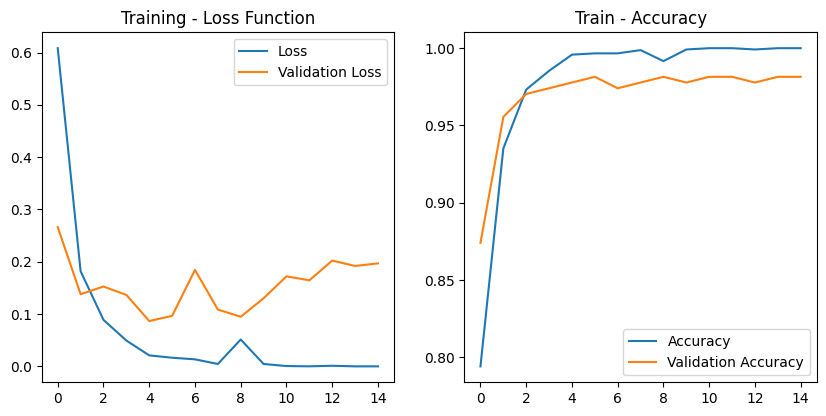

In [13]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(CNN_BaseModel.history['loss'], label='Loss')
plt.plot(CNN_BaseModel.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(CNN_BaseModel.history['accuracy'], label='Accuracy')
plt.plot(CNN_BaseModel.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [14]:
# Run the model against the test data
# Calculate accuracy and loss
BaseModelTesting = BaseModel.evaluate(TestSet, verbose=False)
print('Loss: '+ '%.4f' % BaseModelTesting[0])
print('Accuracy: '+ '%.4f' % BaseModelTesting[1])

Loss: 0.1329
Accuracy: 0.9733


In [15]:
# Here we create a simple CNN with one convolutional block and one dense layer
SimpleModel = Sequential()

# Convolutional block
# 32 filters, 3x3 kernel, input shape (200, 200, 1) for grayscale images
# Pooling to reduce spatial dimensions
SimpleModel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)))
SimpleModel.add(MaxPool2D((2, 2)))

# Flatten the output of the convolutional layers to form a single long feature vector
SimpleModel.add(Flatten())

# Add dropout for regularization
SimpleModel.add(Dropout(0.5))  # Dropout 50% of the nodes during training to reduce overfitting

# Dense layer for output
SimpleModel.add(Dense(128, activation='relu'))  # Dense layer with 128 units
SimpleModel.add(Dense(2, activation='softmax'))  # Output layer with softmax activation, for 2 classes

# Compile the model
SimpleModel.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to see the structure and parameters
SimpleModel.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 313632)            0         
                                                                 
 dropout_1 (Dropout)         (None, 313632)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               40145024  
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                      

In [16]:
# Compile the model and run
SimpleModel.compile(optimizer=RMSprop(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])
CNN_SimpleModel = SimpleModel.fit(TrainSet,validation_data=ValidationSet,epochs=15,steps_per_epoch=120)

Epoch 1/15
120/120 [==============================] - 13s 98ms/step - loss: 0.8626 - accuracy: 0.7774 - val_loss: 0.2868 - val_accuracy: 0.8815
Epoch 2/15
120/120 [==============================] - 13s 112ms/step - loss: 0.1754 - accuracy: 0.9393 - val_loss: 0.1462 - val_accuracy: 0.9481
Epoch 3/15
120/120 [==============================] - 12s 104ms/step - loss: 0.0933 - accuracy: 0.9762 - val_loss: 0.1073 - val_accuracy: 0.9741
Epoch 4/15
120/120 [==============================] - 12s 97ms/step - loss: 0.0160 - accuracy: 0.9979 - val_loss: 0.0938 - val_accuracy: 0.9815
Epoch 5/15
120/120 [==============================] - 12s 97ms/step - loss: 0.0074 - accuracy: 0.9979 - val_loss: 0.1154 - val_accuracy: 0.9852
Epoch 6/15
120/120 [==============================] - 12s 97ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1316 - val_accuracy: 0.9852
Epoch 7/15
120/120 [==============================] - 12s 97ms/step - loss: 3.0532e-04 - accuracy: 1.0000 - val_loss: 0.1629 - val_acc

Text(0.5, 1.0, 'Train - Accuracy')

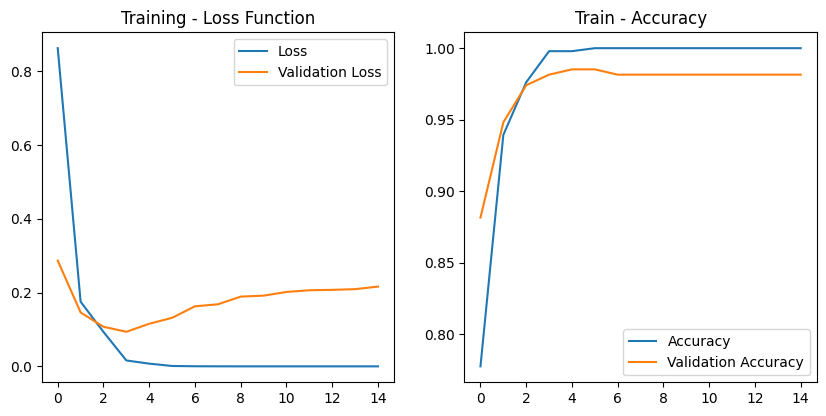

In [17]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(CNN_SimpleModel.history['loss'], label='Loss')
plt.plot(CNN_SimpleModel.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(CNN_SimpleModel.history['accuracy'], label='Accuracy')
plt.plot(CNN_SimpleModel.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [18]:
# Run the model against the test data
# Calculate accuracy and loss
SimpleModelTesting = SimpleModel.evaluate(TestSet, verbose=False)
print('Loss: '+ '%.4f' % SimpleModelTesting[0])
print('Accuracy: '+ '%.4f' % SimpleModelTesting[1])

Loss: 0.0723
Accuracy: 0.9867


In [19]:
ComplexModel = Sequential()
# Convolution block, 32 filters, 5 x 5 kernel
ComplexModel.add(Conv2D(32,(5,5),activation="relu",input_shape=(200,200,1)))
ComplexModel.add(MaxPool2D((2,2)))
ComplexModel.add(Dropout(0.2))

# Convolution block, 64 filters, 3 x 3 kernel
ComplexModel.add(Conv2D(64,(3,3),activation="relu"))
ComplexModel.add(MaxPool2D((2,2)))
ComplexModel.add(Dropout(0.2))

# Convolution block, 128 filters, 3 x 3 kernel
ComplexModel.add(Conv2D(128,(3,3),activation="relu"))
ComplexModel.add(MaxPool2D((2,2)))
ComplexModel.add(Dropout(0.2))

# Convolution block, 256 filters, 3 x 3 kernel
ComplexModel.add(Conv2D(256,(3,3),activation="relu"))
ComplexModel.add(MaxPool2D((2,2)))
ComplexModel.add(Dropout(0.2))

# Final block, flatten and categorize
ComplexModel.add(Flatten())
ComplexModel.add(Dropout(0.5))
ComplexModel.add(Dense(512,activation="relu"))
ComplexModel.add(Dense(2,activation="softmax"))

print(ComplexModel.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 196, 196, 32)      832       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 98, 98, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 98, 98, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 48, 48, 64)       

In [20]:
# Compile the model and run
ComplexModel.compile(optimizer=RMSprop(learning_rate=0.001),loss="categorical_crossentropy",metrics=["accuracy"])
CNN_ComplexModel = ComplexModel.fit(TrainSet,validation_data=ValidationSet,epochs=15,steps_per_epoch=120)


Epoch 1/15
120/120 [==============================] - 16s 106ms/step - loss: 0.7296 - accuracy: 0.7079 - val_loss: 0.4126 - val_accuracy: 0.8407
Epoch 2/15
120/120 [==============================] - 12s 101ms/step - loss: 0.4355 - accuracy: 0.8126 - val_loss: 0.3177 - val_accuracy: 0.8889
Epoch 3/15
120/120 [==============================] - 12s 98ms/step - loss: 0.3407 - accuracy: 0.8477 - val_loss: 0.3144 - val_accuracy: 0.8741
Epoch 4/15
120/120 [==============================] - 12s 100ms/step - loss: 0.2642 - accuracy: 0.8874 - val_loss: 0.1930 - val_accuracy: 0.9222
Epoch 5/15
120/120 [==============================] - 12s 101ms/step - loss: 0.2014 - accuracy: 0.9230 - val_loss: 0.2346 - val_accuracy: 0.9111
Epoch 6/15
120/120 [==============================] - 12s 100ms/step - loss: 0.1622 - accuracy: 0.9393 - val_loss: 0.1301 - val_accuracy: 0.9630
Epoch 7/15
120/120 [==============================] - 12s 101ms/step - loss: 0.1338 - accuracy: 0.9490 - val_loss: 0.0944 - val_acc

Text(0.5, 1.0, 'Train - Accuracy')

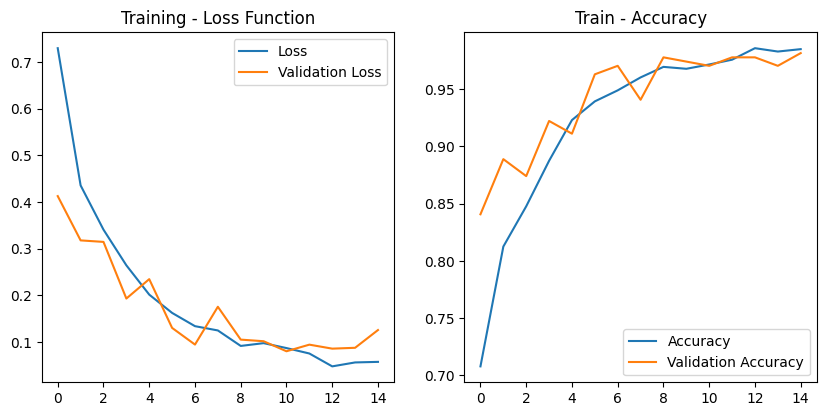

In [21]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(CNN_ComplexModel.history['loss'], label='Loss')
plt.plot(CNN_ComplexModel.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(CNN_ComplexModel.history['accuracy'], label='Accuracy')
plt.plot(CNN_ComplexModel.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [22]:
ComplexModelTesting = ComplexModel.evaluate(TestSet, verbose=False)
print('Loss: '+ '%.4f' % ComplexModelTesting[0])
print('Accuracy: '+ '%.4f' % ComplexModelTesting[1])

Loss: 0.0893
Accuracy: 0.9833


<h3>Results and Analysis</h3>
The project's objective was to develop a machine learning model capable of classifying brain MRI scans into two categories: with tumor (yes) or without tumor (no). To this end, three CNN models—BaseModel, SimpleModel, and ComplexModel—were trained and evaluated. The summary table provided offers a clear comparison of the performance metrics for each model on the test dataset, which consisted of 10% of the total available data.

| Model   | Test Loss | Test Accuracy |
|---------|-----------|---------------|
| Base    | 0.1329    | 0.9733        |
| Simple  | 0.0723    | 0.9867        |
| Complex | 0.0893    | 0.9833        |
|         |           |               |

The results show that all three models achieved high accuracy, with the SimpleModel obtaining the highest test accuracy of 98.67%. Interestingly, the ComplexModel, despite its sophistication, did not outperform the SimpleModel. It's worth noting that a more complex model does not always equate to better performance, especially if the complexity does not translate to capturing relevant patterns in the data.

The BaseModel, with the least complexity, showed commendable performance with an accuracy of 97.33%, but the highest test loss at 0.1329. The increased loss suggests that, on average, the predictions made by the BaseModel were less confident compared to the other models.

Examining the training loss function graphs from the previous section, we see that validation loss tends to start increasing during the later epoch cycles.  Loss quantifies the difference between the predicted values and the true values and provides a summary of the model's errors in its predictions. The validation loss decreases initially alongside the training loss, which is a good sign as it means the model is generalizing well to new data. However, as the epochs increase the validation loss starts to increase. This might indicate the beginning of overfitting the data.

The performance of the three models suggests that the SimpleModel strikes the best balance between complexity and effectiveness for this particular dataset. While the ComplexModel has a lower test loss than the BaseModel, it does not translate into a higher accuracy, indicating that there might be diminishing returns on adding complexity beyond a certain point.

<h3>Conclusion</h3>
The results of the project indicate a successful application of Convolutional Neural Networks (CNNs) in the classification of brain MRI scans, achieving impressive accuracies across three distinct model architectures. The SimpleModel, in particular, emerged as the most effective, striking an optimal balance between model complexity and predictive performance. However, there exists opportunities to improve the models.

I might consider experimenting with the activation function. While ReLU is commonly used for its efficiency in training deep networks, a sigmoid activation function could be explored, especially in the final output layer for binary classification tasks, as it maps predictions to a probability between 0 and 1, which could be more interpretable in the context of medical diagnostics.

Refining the architecture could also lead to performance gains. This can be achieved by experimenting with different numbers of layers and filters, kernel sizes, and dropout. I was somewhat limited in the resources available to me as my personal computer does not contain a GPU.  Instead I had to rely on Google Colab.  With additional resources, it would easier to experiment to try to improve performance.

In conclusion, this project has demonstrated the efficacy of CNNs in image classification tasks within the medical imaging domain. It was a good learning experience for me as I have never been exposed to neural networks or even dealt with images in a machine learning context.





